In [ ]:
import pickle
from pathlib import Path

import torch
import xarray as xr
from aurora import Batch, Metadata

from aurora_hpc.aurora_loss import mae

In [2]:
with open("preds.pkl", "rb") as f:
    preds = pickle.load(f)

In [3]:
download_path = Path("../era5/era_v_inf/")

static_vars_ds = xr.open_dataset(download_path / "static.nc", engine="netcdf4")
surf_vars_ds = xr.open_dataset(
    download_path / "2023-01-surface-level.nc", engine="netcdf4"
)
atmos_vars_ds = xr.open_dataset(
    download_path / "2023-01-atmospheric.nc", engine="netcdf4"
)

In [4]:
losses = []

for i, pred in enumerate(preds):
    batch = Batch(
        surf_vars={
            # First select time points `i` and `i - 1`. Afterwards, `[None]` inserts a
            # batch dimension of size one.
            "2t": torch.from_numpy(surf_vars_ds["t2m"].values[[i+2]][None]),
            "10u": torch.from_numpy(surf_vars_ds["u10"].values[[i+2]][None]),
            "10v": torch.from_numpy(surf_vars_ds["v10"].values[[i+2]][None]),
            "msl": torch.from_numpy(surf_vars_ds["msl"].values[[i+2]][None]),
        },
        static_vars={
            # The static variables are constant, so we just get them for the first time.
            "z": torch.from_numpy(static_vars_ds["z"].values[0]),
            "slt": torch.from_numpy(static_vars_ds["slt"].values[0]),
            "lsm": torch.from_numpy(static_vars_ds["lsm"].values[0]),
        },
        atmos_vars={
            "t": torch.from_numpy(atmos_vars_ds["t"].values[[i+2]][None]),
            "u": torch.from_numpy(atmos_vars_ds["u"].values[[i+2]][None]),
            "v": torch.from_numpy(atmos_vars_ds["v"].values[[i+2]][None]),
            "q": torch.from_numpy(atmos_vars_ds["q"].values[[i+2]][None]),
            "z": torch.from_numpy(atmos_vars_ds["z"].values[[i+2]][None]),
        },
        metadata=Metadata(
            lat=torch.from_numpy(surf_vars_ds.latitude.values),
            lon=torch.from_numpy(surf_vars_ds.longitude.values),
            # Converting to `datetime64[s]` ensures that the output of `tolist()` gives
            # `datetime.datetime`s. Note that this needs to be a tuple of length one:
            # one value for every batch element.
            time=(surf_vars_ds.valid_time.values.astype("datetime64[s]").tolist()[i],),
            atmos_levels=tuple(int(level) for level in atmos_vars_ds.pressure_level.values),
        ),
    )
    loss = mae(pred, batch)
    losses.append(loss.item())

In [5]:
import matplotlib.pyplot as plt

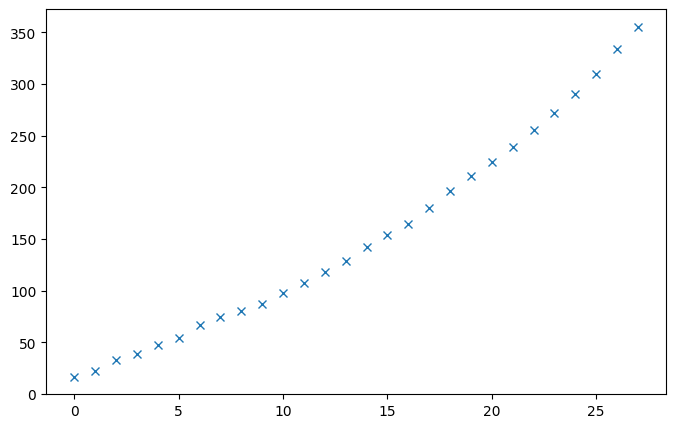

In [6]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(losses, linestyle="", marker="x")

In [7]:
from torch.nn import MSELoss

In [8]:
surf_losses = {}
atmos_losses = {}

for i, pred in enumerate(preds):
    batch = Batch(
        surf_vars={
            # First select time points `i` and `i - 1`. Afterwards, `[None]` inserts a
            # batch dimension of size one.
            "2t": torch.from_numpy(surf_vars_ds["t2m"].values[[i+2]][None]),
            "10u": torch.from_numpy(surf_vars_ds["u10"].values[[i+2]][None]),
            "10v": torch.from_numpy(surf_vars_ds["v10"].values[[i+2]][None]),
            "msl": torch.from_numpy(surf_vars_ds["msl"].values[[i+2]][None]),
        },
        static_vars={
            # The static variables are constant, so we just get them for the first time.
            "z": torch.from_numpy(static_vars_ds["z"].values[0]),
            "slt": torch.from_numpy(static_vars_ds["slt"].values[0]),
            "lsm": torch.from_numpy(static_vars_ds["lsm"].values[0]),
        },
        atmos_vars={
            "t": torch.from_numpy(atmos_vars_ds["t"].values[[i+2]][None]),
            "u": torch.from_numpy(atmos_vars_ds["u"].values[[i+2]][None]),
            "v": torch.from_numpy(atmos_vars_ds["v"].values[[i+2]][None]),
            "q": torch.from_numpy(atmos_vars_ds["q"].values[[i+2]][None]),
            "z": torch.from_numpy(atmos_vars_ds["z"].values[[i+2]][None]),
        },
        metadata=Metadata(
            lat=torch.from_numpy(surf_vars_ds.latitude.values),
            lon=torch.from_numpy(surf_vars_ds.longitude.values),
            # Converting to `datetime64[s]` ensures that the output of `tolist()` gives
            # `datetime.datetime`s. Note that this needs to be a tuple of length one:
            # one value for every batch element.
            time=(surf_vars_ds.valid_time.values.astype("datetime64[s]").tolist()[i],),
            atmos_levels=tuple(int(level) for level in atmos_vars_ds.pressure_level.values),
        ),
    )

    loss_fn = MSELoss()
    
    for k, v in pred.surf_vars.items():
        loss = loss_fn(v, batch.surf_vars[k][:, :, :720, :]).item()
        if k not in surf_losses:
            surf_losses[k] = [loss]
        else:
            surf_losses[k].append(loss)
            
    for k, v in pred.atmos_vars.items():
        loss = loss_fn(v, batch.atmos_vars[k][:, :, :, :720, :]).item()
        if k not in atmos_losses:
            atmos_losses[k] = [loss]
        else:
            atmos_losses[k].append(loss)    

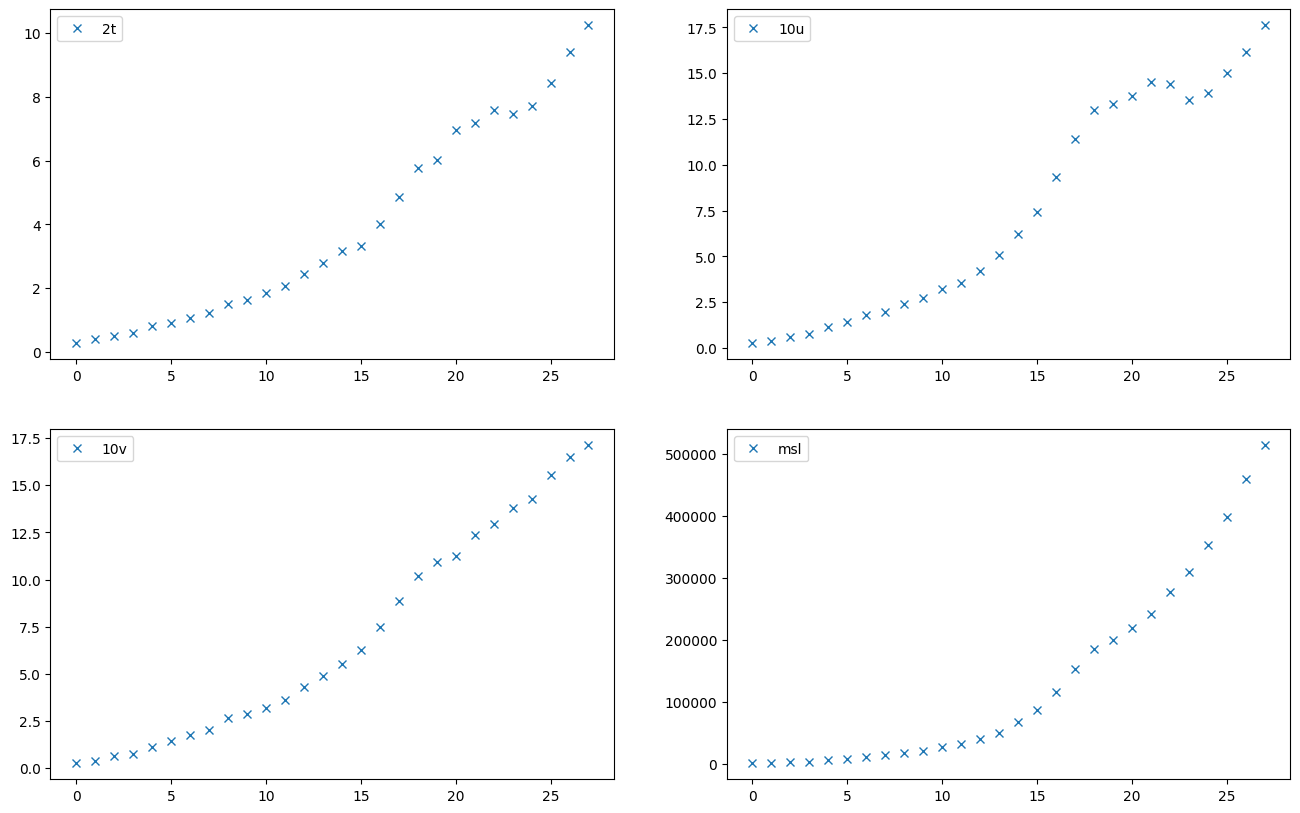

In [9]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16,10))

for i, k in enumerate(surf_losses):
    i_0 = i//2
    i_1 = i%2
    axs[i_0, i_1].plot(surf_losses[k], linestyle="", marker="x", label=k)
    axs[i_0, i_1].legend()

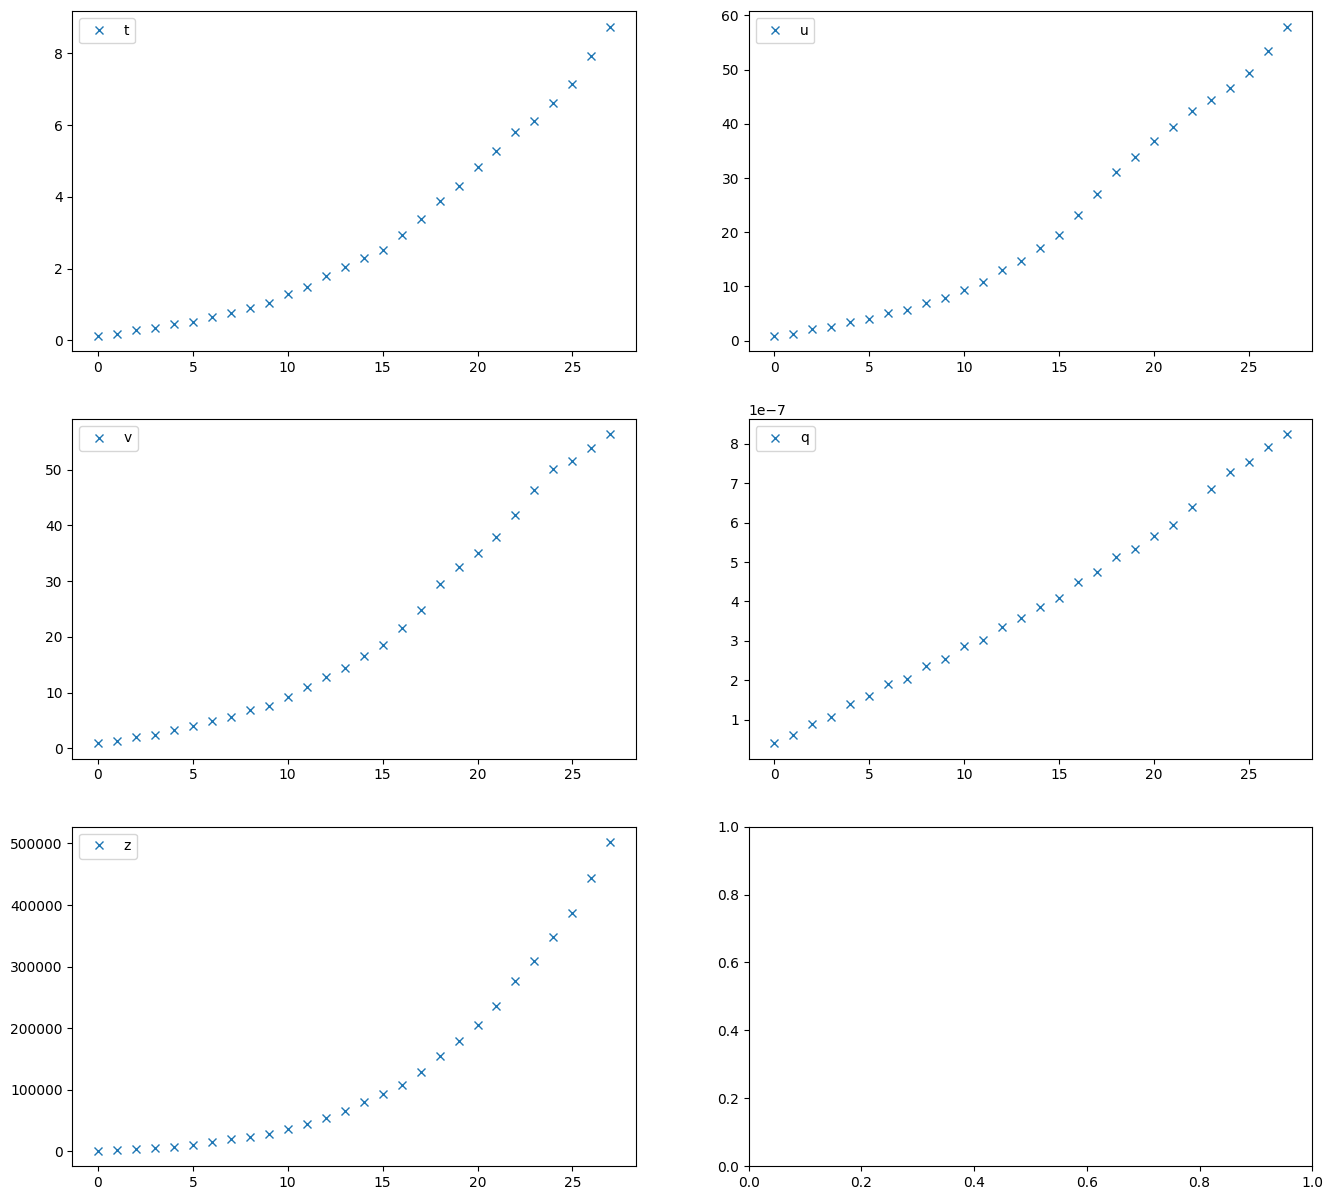

In [10]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(16,15))

for i, k in enumerate(atmos_losses):
    i_0 = i//2
    i_1 = i%2
    axs[i_0, i_1].plot(atmos_losses[k], linestyle="", marker="x", label=k)
    axs[i_0, i_1].legend()

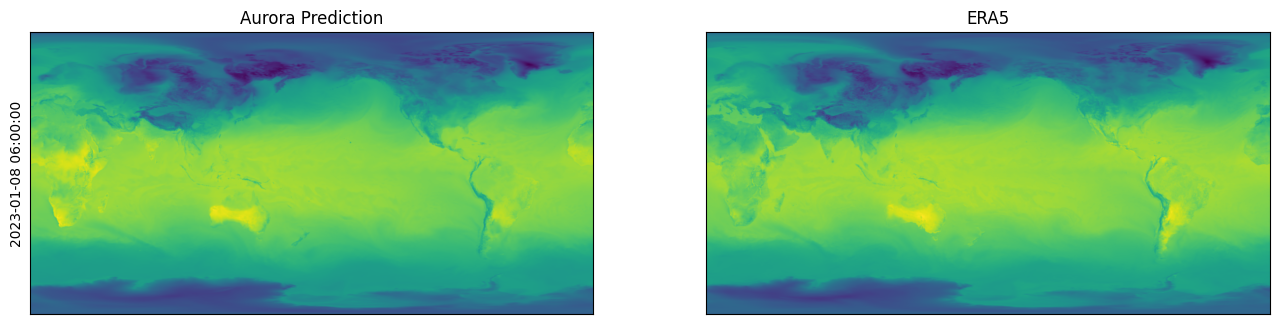

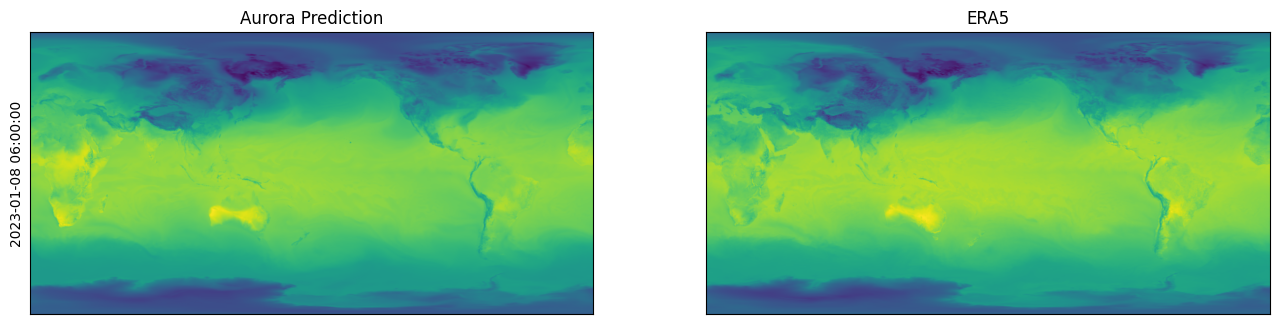

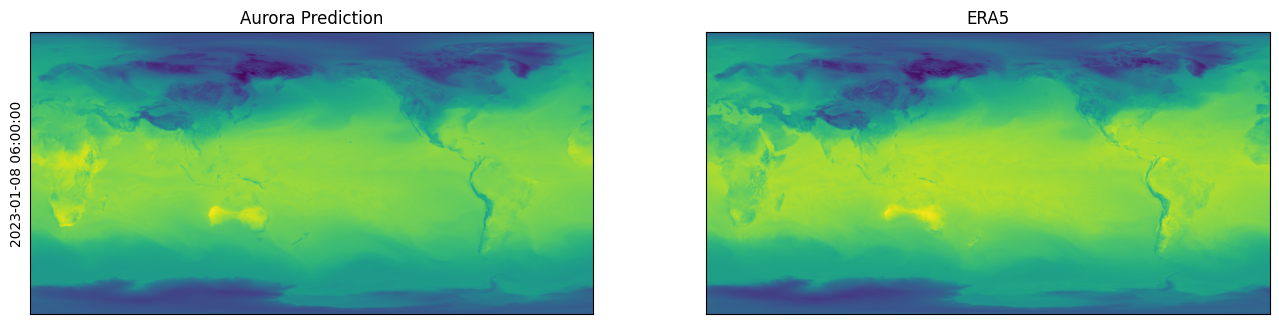

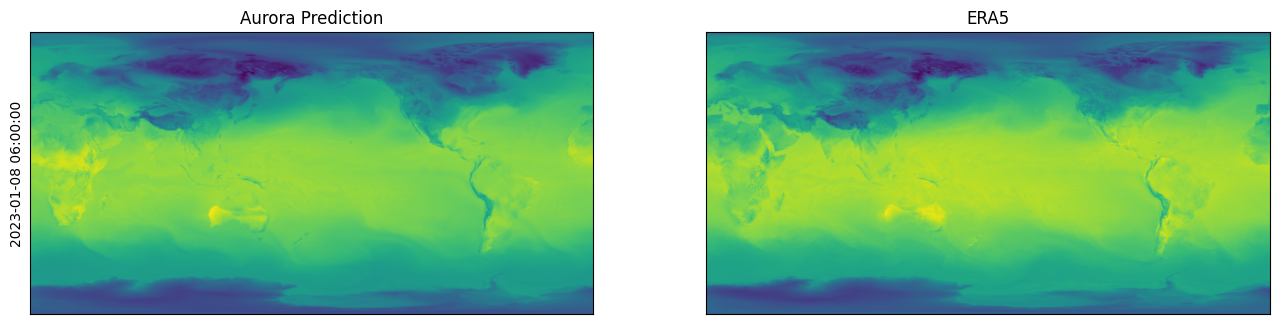

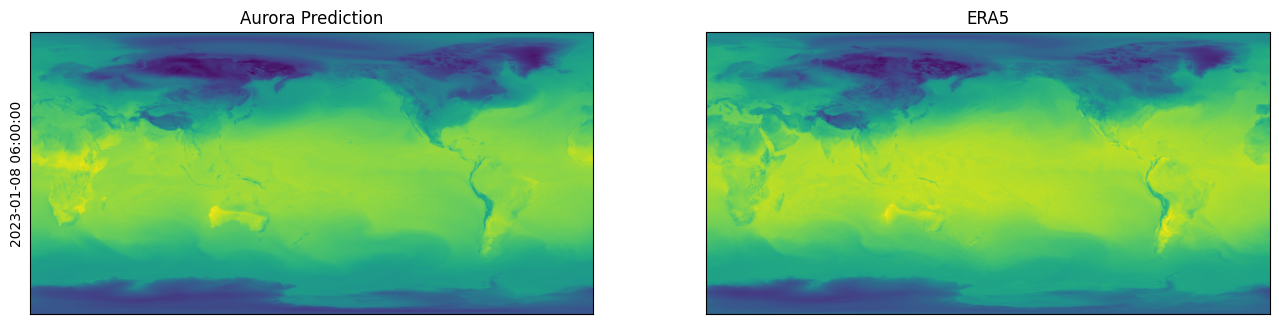

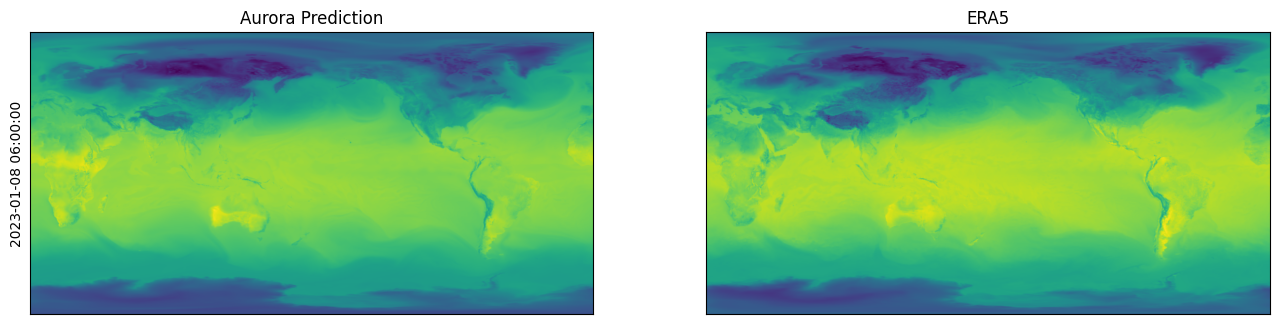

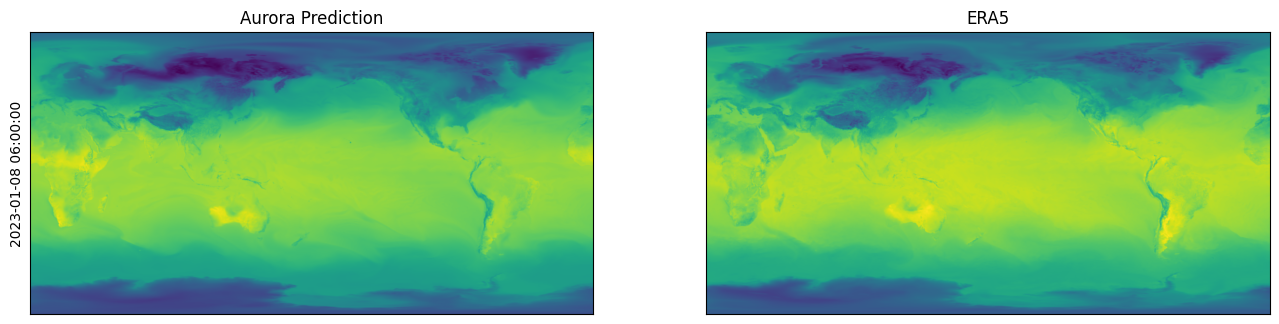

In [11]:
figures = []

for i in range(0, len(preds), 4):
    fig, axs = plt.subplots(ncols=2, figsize=(16,10))
    
    axs[0].imshow(preds[i].surf_vars["2t"][0, 0].numpy() )#- 273.15, vmin=-50, vmax=50)
    axs[0].set_ylabel(str(pred.metadata.time[0]))
    axs[0].set_title("Aurora Prediction")
    axs[0].set_xticks([])
    axs[0].set_yticks([])

    axs[1].imshow(surf_vars_ds["t2m"][i].values )#- 273.15, vmin=-50, vmax=50)
    axs[1].set_title("ERA5")
    axs[1].set_xticks([])
    axs[1].set_yticks([])

    figures.append(fig)

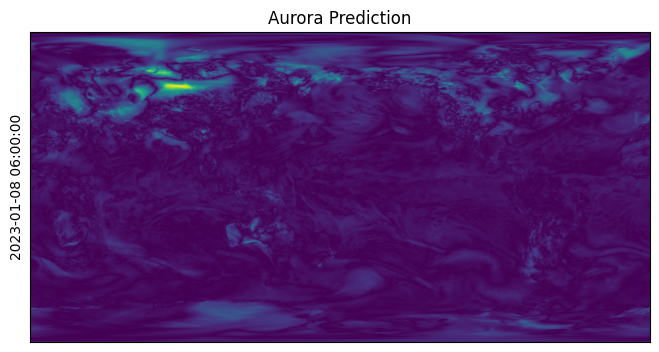

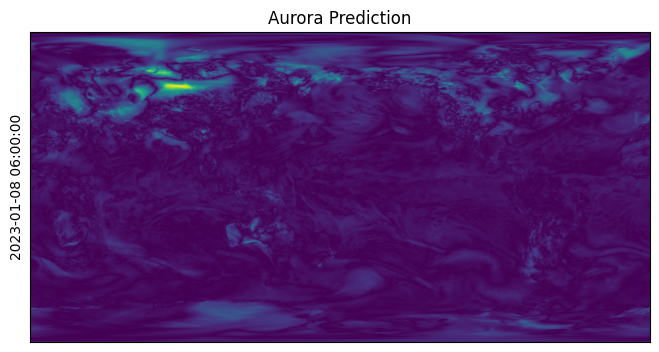

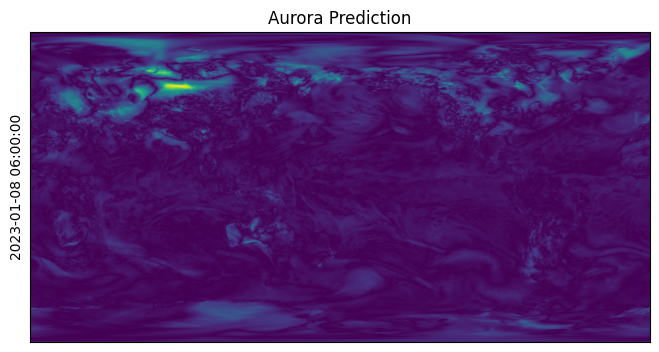

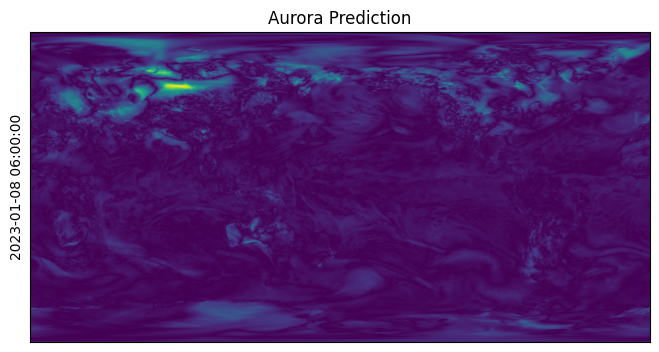

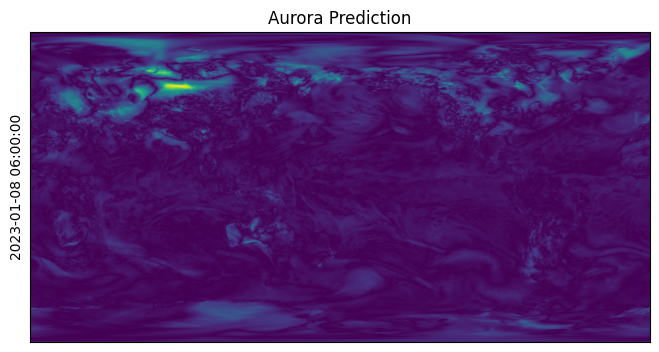

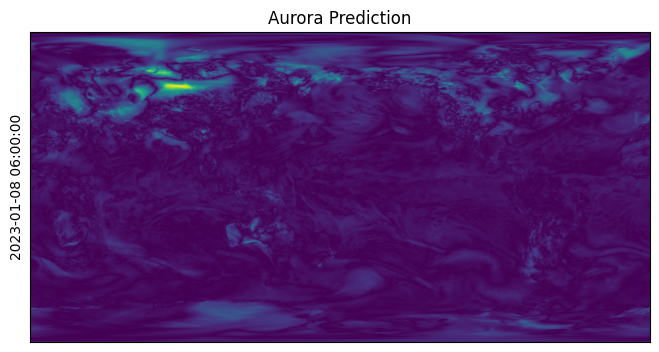

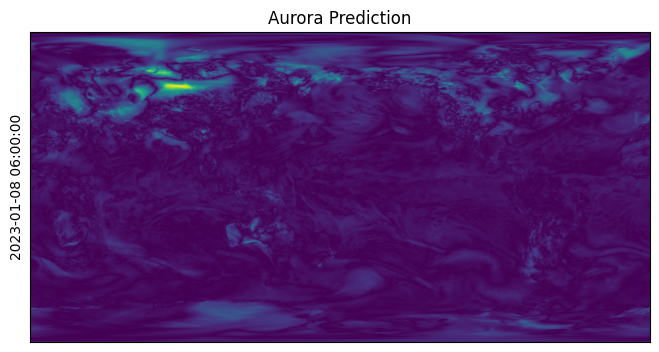

In [12]:
figures = []

for i in range(0, len(preds), 4):
    fig, axs = plt.subplots(ncols=1, figsize=(8,5))
    
    axs.imshow(((pred.surf_vars["2t"][0, 0].numpy()-surf_vars_ds["t2m"][29].values[:720,:])**2)**0.5)
    axs.set_ylabel(str(pred.metadata.time[0]))
    axs.set_title("Aurora Prediction")
    axs.set_xticks([])
    axs.set_yticks([])

    figures.append(fig)